<a href="https://colab.research.google.com/github/lazarnouche/SEM_Contour_Detection/blob/main/SEM_profile_detection_deeplabv3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 19 18:44:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              47W / 400W |    595MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

In [ ]:
from google.colab import drive
import os
import json
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "/content/drive/Othercomputers/My MacBook Pro /context_chatbot/doc/untracked_files/SEM"
os.chdir(PATH)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as tf
import torchvision.models.segmentation
import cv2
from src.datasets import get_data_loaders,train_transforms,valid_transforms
from src.datasets_extended import get_images_only,SegmentationDataset_Without_Mask_Images
from src.utils import save_model, save_plots_valid_only
from src.utils_extended import create_mask
from src.engine_extended import train_model, validate_model
from src.config import IMG_SIZE, LABEL_COLORS, Learning_Rate,BATCH_SIZE
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
out_dir = os.path.join(PATH, 'outputs')
out_dir_valid_preds = os.path.join(PATH, 'outputs', 'valid_preds')
os.makedirs(out_dir, exist_ok=True)
os.makedirs(out_dir_valid_preds, exist_ok=True)

In [ ]:
root_path = 'split_data'

In [ ]:
train_images, valid_images = get_images_only(
    root_path='split_data'
)

In [ ]:
len(train_images) , len(valid_images)

(126, 13)

In [ ]:
# transformImg=tf.Compose([tf.ToPILImage(), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transformAnn=tf.Compose([tf.ToPILImage(), tf.ToTensor()])
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((IMG_SIZE,IMG_SIZE)), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((IMG_SIZE,IMG_SIZE)), tf.ToTensor()])

In [ ]:
modelPath = os.path.join(PATH,"models/model_EPOCH_40.torch")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, len(LABEL_COLORS), kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)  # Set net to GPU or CPU
model.load_state_dict(torch.load(modelPath,map_location=torch.device('cpu'))) # Load trained model


optimizer=torch.optim.Adam(params=model.parameters(),lr=Learning_Rate) # Create adam optimizer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_tfms = train_transforms(IMG_SIZE)
valid_tfms = valid_transforms(IMG_SIZE)

train_dataset = SegmentationDataset_Without_Mask_Images(train_images,train_tfms,transformImg,transformAnn)
valid_dataset = SegmentationDataset_Without_Mask_Images(valid_images,valid_tfms,transformImg,transformAnn)

In [ ]:
im_path = os.path.join(train_dataset.image_paths[0])
img_path_root = os.path.join('images',os.path.split(im_path)[1])
image, mask, label =  create_mask(img_path_root)

In [ ]:
def diplay_image_and_mask(dataset,data_transforms):

  idx = random.randrange(len(dataset))
  image,mask = dataset.__getitem__(idx)
  fig, ax = plt.subplots(1,2)
  image_normalized = cv2.normalize(image.numpy().transpose((1, 2, 0)), None, 0.0, 1.0, cv2.NORM_MINMAX)
  image_normalized_scaled = (image_normalized * 255).astype('uint8')
  ax[0].imshow(image_normalized_scaled)
  ax[1].imshow(mask.numpy())
  [ax_.axis("off") for ax_ in ax]

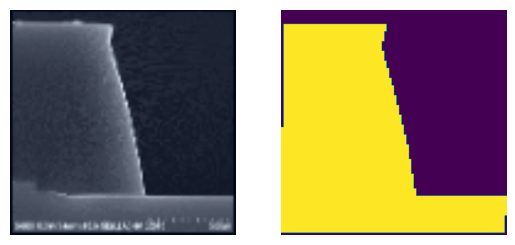

In [ ]:
diplay_image_and_mask(valid_dataset,valid_transforms)

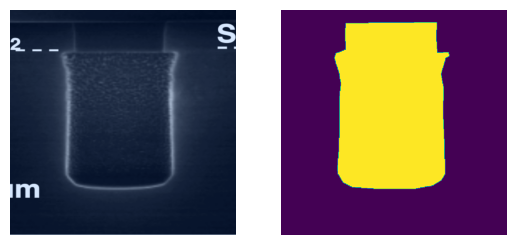

In [ ]:
diplay_image_and_mask(train_dataset,train_transforms)

In [ ]:
train_dataloader, valid_dataloader = get_data_loaders(
        train_dataset, valid_dataset, batch_size=BATCH_SIZE
    )

In [ ]:
len(valid_dataloader) ,len(train_dataloader)

(3, 31)

EPOCH: 1


|                    | 31/? [04:18<00:00,  8.33s/it]
 75%|███████████████     | 3/4 [00:13<00:04,  4.59s/it]


1 train loss: 0.3807505460516099, valid loss: 0.32200975219408673 
EPOCH: 2


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.89it/s]


2 train loss: 0.34360444209268015, valid loss: 0.32861092686653137 
EPOCH: 3


|                    | 31/? [00:39<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.97it/s]


3 train loss: 0.330903850255474, valid loss: 0.31923309961954754 
EPOCH: 4


|                    | 31/? [00:39<00:00,  1.27s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.08it/s]


4 train loss: 0.3248387075239612, valid loss: 0.3092366059621175 
EPOCH: 5


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.09it/s]


5 train loss: 0.313297156364687, valid loss: 0.3131834069887797 
EPOCH: 6


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.06it/s]


6 train loss: 0.29836327414358815, valid loss: 0.30726637442906696 
EPOCH: 7


|                    | 31/? [00:39<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.96it/s]


7 train loss: 0.28300474199556536, valid loss: 0.2917994906504949 
EPOCH: 8


|                    | 31/? [00:39<00:00,  1.27s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.95it/s]


8 train loss: 0.2849881788415293, valid loss: 0.28937895596027374 
EPOCH: 9


|                    | 31/? [00:39<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.92it/s]


9 train loss: 0.2734008239161584, valid loss: 0.2862207293510437 
EPOCH: 10


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.97it/s]


10 train loss: 0.26688048003181336, valid loss: 0.2883940289417903 
EPOCH: 11


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.04it/s]


11 train loss: 0.25681244750176707, valid loss: 0.27389077345530194 
EPOCH: 12


|                    | 31/? [00:39<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.03it/s]


12 train loss: 0.2433759243257584, valid loss: 0.26119260986646015 
EPOCH: 13


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.02it/s]


13 train loss: 0.23819880956603634, valid loss: 0.25822216272354126 
EPOCH: 14


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.03it/s]


14 train loss: 0.2367374848934912, valid loss: 0.2598932534456253 
EPOCH: 15


|                    | 31/? [00:39<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.97it/s]


15 train loss: 0.22480500561575736, valid loss: 0.24505447844664255 
EPOCH: 16


|                    | 31/? [00:39<00:00,  1.28s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.11it/s]


16 train loss: 0.225845625323634, valid loss: 0.25885990758736926 
EPOCH: 17


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.95it/s]


17 train loss: 0.2152544832037341, valid loss: 0.2564438929160436 
EPOCH: 18


|                    | 31/? [00:39<00:00,  1.27s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.01it/s]


18 train loss: 0.20963720688896795, valid loss: 0.24269278347492218 
EPOCH: 19


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.94it/s]


19 train loss: 0.21305087449089175, valid loss: 0.22140511373678842 
EPOCH: 20


|                    | 31/? [00:39<00:00,  1.27s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.87it/s]


20 train loss: 0.21163813385271257, valid loss: 0.24614685773849487 
EPOCH: 21


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.98it/s]


21 train loss: 0.20073623378430644, valid loss: 0.2268837442000707 
EPOCH: 22


|                    | 31/? [00:38<00:00,  1.24s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.02it/s]


22 train loss: 0.18908169769471692, valid loss: 0.2261132001876831 
EPOCH: 23


|                    | 31/? [00:39<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.97it/s]


23 train loss: 0.18618350644265452, valid loss: 0.2208713193734487 
EPOCH: 24


|                    | 31/? [00:39<00:00,  1.27s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.13it/s]


24 train loss: 0.1858750533673071, valid loss: 0.2232882728179296 
EPOCH: 25


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.08it/s]


25 train loss: 0.17683548792715995, valid loss: 0.20610939462979636 
EPOCH: 26


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.88it/s]


26 train loss: 0.17726682222658588, valid loss: 0.20668719708919525 
EPOCH: 27


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.03it/s]


27 train loss: 0.17409830732691672, valid loss: 0.20471482972304025 
EPOCH: 28


|                    | 31/? [00:38<00:00,  1.25s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.00it/s]


28 train loss: 0.18042458786118415, valid loss: 0.22906136512756348 
EPOCH: 29


|                    | 31/? [00:38<00:00,  1.26s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  3.85it/s]


29 train loss: 0.17138807571703388, valid loss: 0.1974210093418757 
EPOCH: 30


|                    | 31/? [00:39<00:00,  1.27s/it]
 75%|███████████████     | 3/4 [00:00<00:00,  4.03it/s]


30 train loss: 0.163953959941864, valid loss: 0.1968231052160263 


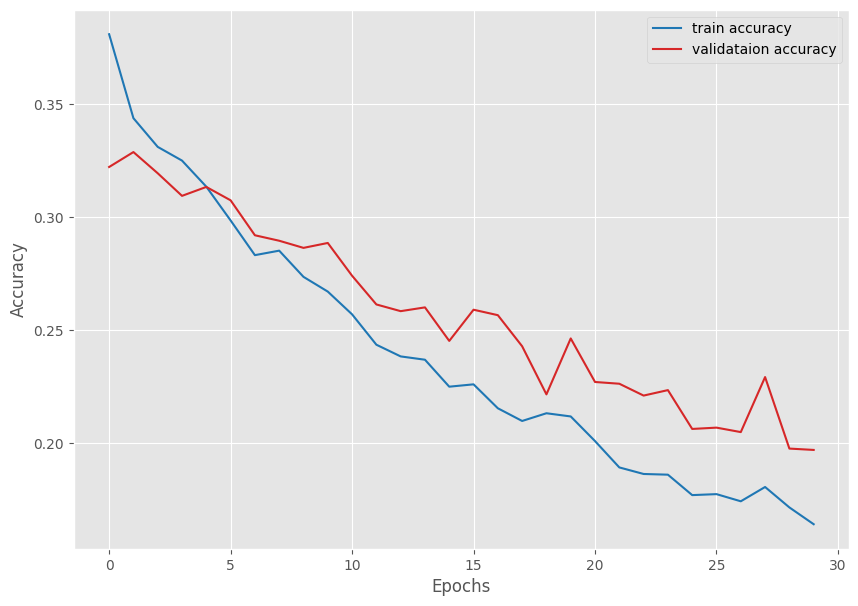

In [ ]:
EPOCHS = 30
name = '19_feb'
train_loss,valid_loss = [], []
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
  print(f"EPOCH: {epoch + 1}")
  train_epoch_loss = train_model(model,train_dataloader,device,optimizer,criterion)
  valid_epoch_loss = validate_model(model,valid_dataloader,device,criterion)
  print(epoch + 1,f"train loss: {train_epoch_loss}, valid loss: {valid_epoch_loss} " )
  if epoch % 10 == 0:
    torch.save(model.state_dict(),   PATH+ os.sep+"models/model_EPOCH_"+name+"_"+str(epoch) + ".torch")
  train_loss.append(train_epoch_loss)
  valid_loss.append(valid_epoch_loss)
save_plots_valid_only(train_loss, valid_loss,PATH+ os.sep+"models")

In [ ]:
torch.save(model.state_dict(),   PATH+ os.sep+"models/model_EPOCH_"+name+"_"+str(epoch) + ".torch")

In [ ]:
# for epoch in range(20,EPOCHS+30,1):
#   print(f"EPOCH: {epoch + 1}")
#   train_epoch_loss = train(Net,train_dataloader,device,optimizer,criterion)
#   valid_epoch_loss = validate(Net,valid_dataloader,device,criterion)
#   print(epoch + 1,f"train loss: {train_epoch_loss}, valid loss: {valid_epoch_loss} " )
#   if epoch % 10 == 0:
#     torch.save(Net.state_dict(),   PATH+ os.sep+"models/model_EPOCH_"+str(epoch) + ".torch")
#   train_loss.append(train_epoch_loss)
#   valid_loss.append(valid_epoch_loss)
# save_plots(train_loss, valid_loss,PATH+ os.sep+"models")

In [ ]:
# prog_bar = tqdm(train_dataloader, total=BATCH_SIZE, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
#   counter = 0
#   train_running_loss = 0.0
#   for i, data in enumerate(prog_bar):
#       counter += 1
#       images, ann = data[0].to(device), data[1].to(device)
#       images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
#       ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
#       Pred=Net(images)['out'] # make prediction
#       Net.zero_grad()
#       # criterion = torch.nn.CrossEntropyLoss() # Set loss function
#       train_loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
#       train_loss.backward() # Backpropogate loss
#       optimizer.step() # Apply gradient descent change to weight
#       seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
#       train_running_loss += train_loss.item()

In [ ]:
# def ReadRandomImage(data_images,transforms):

#   idx=np.random.randint(0,len(data_images)) # Pick random image
#   im_path = os.path.join(PATH,data_images[idx])
#   img_path_root = os.path.join(PATH,'images',os.path.split(im_path)[1])
#   image, mask, label =  create_mask(img_path_root)
#   tfms = transforms(IMG_SIZE)
#   transformed = tfms(image=image, mask=mask)
#   image = transformed['image']
#   mask = transformed['mask']

#   AnnMap = np.zeros(image.shape[0:2],np.float32) # Segmentation map
#   if label =="cross":  AnnMap[ mask == 255 ] = 1
#   elif label =="tsv":  AnnMap[ mask  == 255 ] = 2
#   else:  AnnMap[ mask  == 255 ] = 3

#   Img=transformImg(image)
#   AnnMap=transformAnn(AnnMap)

#   return Img,AnnMap

In [ ]:
# def LoadBatch(data_images,transforms): # Load batch of images
#     images = torch.zeros([BATCH_SIZE,3,IMG_SIZE,IMG_SIZE])
#     ann = torch.zeros([BATCH_SIZE, IMG_SIZE, IMG_SIZE])

#     for i in range(BATCH_SIZE):
#         images[i],ann[i]=ReadRandomImage(data_images,transforms)

#     return images, ann

In [ ]:
# def LoadValid(data_images,transforms,valid_batch_size):
#     images = torch.zeros([valid_batch_size,3,IMG_SIZE,IMG_SIZE])
#     ann = torch.zeros([valid_batch_size, IMG_SIZE, IMG_SIZE])

#     for i in range(valid_batch_size):
#         images[i],ann[i]=ReadRandomImage(data_images,transforms)

#     return images, ann

In [ ]:
# def diplay_image_and_mask(data_images,data_transforms):
#   image,mask = ReadRandomImage(data_images,data_transforms)
#   print(mask.shape)
#   fig, ax = plt.subplots(1,2)
#   image = image.numpy().transpose((1, 2, 0))
#   image_normalized = cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX)
#   # Scale the image to the range [0, 255]
#   image_normalized_scaled = (image_normalized * 255).astype('uint8')
#   mask = mask.numpy()
#   ax[0].imshow(image_normalized_scaled)
#   ax[1].imshow(mask[0,:,:])
#   [ax_.axis("off") for ax_ in ax]

In [ ]:
# diplay_image_and_mask(train_images,train_transforms)

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# for itr in range(10000): # Training loop
#    images,ann=LoadBatch(train_images,train_transforms) # Load taining batch
#    images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
#    print(images.shape)
#    ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
#    Pred=Net(images)['out'] # make prediction
#    Net.zero_grad()
#    criterion = torch.nn.CrossEntropyLoss() # Set loss function
#    train_loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
#    train_loss.backward() # Backpropogate loss
#    optimizer.step() # Apply gradient descent change to weight
#    seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes

#    val_images,val_ann = LoadValid(valid_images,valid_transforms)
#    val_images = torch.autograd.Variable(val_images, requires_grad=False).to(device)
#    val_ann = torch.autograd.Variable(val_ann, requires_grad=False).to(device)
#    val_Pred = Net(val_images)['out']
#    val_loss=criterion(val_Pred, val_ann.long())

#    print(itr,f"train loss: {train_loss.data.cpu().numpy()}, valid loss: {val_loss.data.cpu().numpy()} " )
#    if itr % 2 == 0: #Save model weight once every 60k steps permenant file
#         # print("Saving Model" +str(itr) + ".torch")
#         # da = str(datetime.datetime.now()).split('.')[0]
#         torch.save(Net.state_dict(),   path+ os.sep+"models/model_iter_"+str(itr) + ".torch")

In [ ]:
# from tqdm import tqdm
# from src.metrics import IOUEval

# def train(model,train_dataloader,device,optimizer,criterion,label_color):

#   prog_bar = tqdm(train_dataloader, total=BATCH_SIZE, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
#   counter = 0
#   train_running_loss = 0.0
#   iou_eval = IOUEval(len(label_color))
#   for i, data in enumerate(prog_bar):
#       counter += 1
#       data, target = data[0].to(device), data[1].to(device)
#       data = torch.autograd.Variable(data, requires_grad=False).to(device) # Load image
#       ann = torch.autograd.Variable(target, requires_grad=False).to(device) # Load annotation
#       ann = ann.squeeze()
#       outputs = model(data)['out'] # make prediction
#       model.zero_grad()
#       # criterion = torch.nn.CrossEntropyLoss() # Set loss function
#       loss = criterion(outputs, ann.long()) # Calculate cross entropy loss
#       train_running_loss += loss.item()

#       loss.backward() # Backpropagate loss
#       optimizer.step() # Apply gradient descent change to weight
#       seg = torch.argmax(outputs[0], 0).cpu().detach().numpy()  # Get prediction classes
#       print("training Loss :", loss.data.cpu().numpy())
#       # iou_eval.addBatch(outputs.max(1)[1].data, target.data)
#   train_loss = train_running_loss / counter
#   # overall_acc, per_class_acc, per_class_iu, mIOU = iou_eval.getMetric()

#   return train_loss

In [ ]:
# from src.utils import draw_translucent_seg_maps

# def validate(model,valid_dataloader,device,criterion,label_color,epoch,save_dir):

#   prog_bar = tqdm(valid_dataloader, total=BATCH_SIZE, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
#   counter = 0
#   valid_running_loss = 0.0
#   iou_eval = IOUEval(len(label_color))
#   label_colors_list = list(label_color.values())
#   for i, data in enumerate(prog_bar):
#       counter += 1
#       data, target = data[0].to(device), data[1].to(device)
#       data = torch.autograd.Variable(data, requires_grad=False).to(device) # Load image
#       ann = torch.autograd.Variable(target, requires_grad=False).to(device) # Load annotation
#       ann = ann.squeeze()
#       outputs = model(data)['out'] # make prediction

#       # if i == BATCH_SIZE - 1:
#       #   draw_translucent_seg_maps(
#       #               data,
#       #               outputs,
#       #               epoch,
#       #               i,
#       #               save_dir,
#       #               label_colors_list,
#       #           )



#       model.zero_grad()
#       # criterion = torch.nn.CrossEntropyLoss() # Set loss function
#       loss = criterion(outputs, ann.long()) # Calculate cross entropy loss
#       valid_running_loss += loss.item()
#       loss.backward() # Backpropagate loss
#       optimizer.step() # Apply gradient descent change to weight
#       seg = torch.argmax(outputs[0], 0).cpu().detach().numpy()  # Get prediction classes
#       # print(i, Training Loss=", loss.data.cpu().numpy())
#       # iou_eval.addBatch(outputs.max(1)[1].data, target.data)


#   valid_loss = valid_running_loss / counter
#   # overall_acc, per_class_acc, per_class_iu, mIOU = iou_eval.getMetric()

#   return valid_loss

In [ ]:
# # Initialize `SaveBestModel` class.
# save_best_model = SaveBestModel()
# save_best_iou = SaveBestModelIOU()

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = prepare_model(num_classes=len(ALL_CLASSES)).to(device)
# print(device)
# # if LOAD_MODEL:
# #   ckpt = torch.load("outputs/model.pth", map_location='cpu')
# #   model.load_state_dict(ckpt['model_state_dict'])

# # Total parameters and trainable parameters.
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(
#     p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# criterion = nn.CrossEntropyLoss()


In [ ]:
# scheduler = MultiStepLR(
#     optimizer, milestones=[60], gamma=0.1, verbose=True
# )

In [ ]:
# out_dir_valid_preds = os.path.join(path, 'outputs', 'valid_preds')

In [ ]:
# os.path.isdir(out_dir_valid_preds)

In [ ]:
# EPOCHS = 20
# criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# train_loss, train_pix_acc, train_miou = [], [], []
# valid_loss, valid_pix_acc, valid_miou = [], [], []
# for epoch in range (EPOCHS):
#     print(f"EPOCH: {epoch + 1}")
#     train_epoch_loss, train_epoch_pixacc, train_epoch_miou = train(
#         Net,
#         train_dataloader,
#         device,
#         optimizer,
#         criterion,
#         ALL_CLASSES
#     )
#     valid_epoch_loss, valid_epoch_pixacc, valid_epoch_miou = validate(
#         Net,
#         valid_dataloader,
#         device,
#         criterion,
#         label_color,
#         epoch,
#         save_dir=out_dir_valid_preds
#     )
#     train_loss.append(train_epoch_loss)
#     train_pix_acc.append(train_epoch_pixacc)
#     train_miou.append(train_epoch_miou)
#     valid_loss.append(valid_epoch_loss)
#     valid_pix_acc.append(valid_epoch_pixacc)
#     valid_miou.append(valid_epoch_miou)

#     save_best_model(
#         valid_epoch_loss, epoch, Net, out_dir, name='model_loss'
#     )
#     save_best_iou(
#         valid_epoch_miou, epoch, Net, out_dir, name='model_iou'
#     )

#     print(
#         f"Train Epoch Loss: {train_epoch_loss:.4f},",
#         f"Train Epoch PixAcc: {train_epoch_pixacc:.4f},",
#         f"Train Epoch mIOU: {train_epoch_miou:4f}"
#     )
#     print(
#         f"Valid Epoch Loss: {valid_epoch_loss:.4f},",
#         f"Valid Epoch PixAcc: {valid_epoch_pixacc:.4f}",
#         f"Valid Epoch mIOU: {valid_epoch_miou:4f}"
#     )
#     if True:
#         scheduler.step()
#     print('-' * 50)

# # save_model(EPOCHS, Net, optimizer, criterion, out_dir, name='model')
# # Save the loss and accuracy plots.
# save_plots(
#     train_pix_acc, valid_pix_acc,
#     train_loss, valid_loss,
#     train_miou, valid_miou,
#     out_dir
# )
# print('TRAINING COMPLETE')

In [ ]:
# train_loss, train_pix_acc, train_miou = [], [], []
# valid_loss, valid_pix_acc, valid_miou = [], [], []
# for epoch in range (EPOCHS):
#     print(f"EPOCH: {epoch + 1}")
#     train_epoch_loss, train_epoch_pixacc, train_epoch_miou = train(
#         Net,
#         train_dataloader,
#         device,
#         optimizer,
#         criterion,
#         ALL_CLASSES
#     )
#     valid_epoch_loss, valid_epoch_pixacc, valid_epoch_miou = validate(
#         Net,
#         valid_dataloader,
#         device,
#         criterion,
#         label_color,
#         epoch,
#         save_dir=out_dir_valid_preds
#     )
#     train_loss.append(train_epoch_loss)
#     train_pix_acc.append(train_epoch_pixacc)
#     train_miou.append(train_epoch_miou)
#     valid_loss.append(valid_epoch_loss)
#     valid_pix_acc.append(valid_epoch_pixacc)
#     valid_miou.append(valid_epoch_miou)

#     save_best_model(
#         valid_epoch_loss, epoch, Net, out_dir, name='model_loss'
#     )
#     save_best_iou(
#         valid_epoch_miou, epoch, Net, out_dir, name='model_iou'
#     )

#     print(
#         f"Train Epoch Loss: {train_epoch_loss:.4f},",
#         f"Train Epoch PixAcc: {train_epoch_pixacc:.4f},",
#         f"Train Epoch mIOU: {train_epoch_miou:4f}"
#     )
#     print(
#         f"Valid Epoch Loss: {valid_epoch_loss:.4f},",
#         f"Valid Epoch PixAcc: {valid_epoch_pixacc:.4f}",
#         f"Valid Epoch mIOU: {valid_epoch_miou:4f}"
#     )
#     if True:
#         scheduler.step()
#     print('-' * 50)

# # save_model(EPOCHS, Net, optimizer, criterion, out_dir, name='model')
# # Save the loss and accuracy plots.
# save_plots(
#     train_pix_acc, valid_pix_acc,
#     train_loss, valid_loss,
#     train_miou, valid_miou,
#     out_dir
# )
# print('TRAINING COMPLETE')

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = prepare_model(num_classes=len(ALL_CLASSES)).to(device)
# ckpt = torch.load("outputs/model.pth", map_location='cpu')
# model.load_state_dict(ckpt['model_state_dict'])
# model.eval().to(device)

In [ ]:
#valid_images, valid_masks

In [ ]:
# image = cv2.imread(valid_images[0])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# if IMG_SIZE is not None:
#     image = cv2.resize(image, (int(IMG_SIZE), int(IMG_SIZE)))